In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [333]:
def rbf(x1, x2, gamma=7):
    dx = x1 - x2
    return np.exp(-gamma*np.vdot(dx.T, dx))

## Реализация KRLS

In [350]:
from scipy.linalg import block_diag

class KRLS:
    def clear(self):
        self.K = None
        self.invK = None
        self.alpha = None
        self.P = None
        self.D = []

    def __init__(self, v = 0.5, kernel=rbf):
        self.kernel = kernel
        self.v = v
        self.clear()
    
    def fit(self, X, y):
        if (X.shape[0] != len(y)):
            raise ValueError("Dimensions error")
        
        start = 0
        if self.K is None:
            self.K = np.array([[self.kernel(X[0], X[0])]])
            self.invK = np.array([[1 / self.K[0][0]]])
            self.alpha = np.array([y[0] / self.K[0][0]]).reshape(1, 1)
            self.P = np.array([[1]])
            self.D.append(X[0].reshape(1, X.shape[1]))
            start = 1
        
        for t in range(start, len(y)):
            xt = X[t].reshape(X.shape[1], 1)
            kt = np.array([self.kernel(xi, xt) for xi in self.D]).reshape(len(self.D), 1)
            at = self.invK.dot(kt)
            delta = self.kernel(xt, xt) - np.vdot(kt.T, at)
            if delta > self.v:
                self.D.append(xt)
                self.invK = 1 / delta * np.block([[delta*self.invK + at.dot(at.T), -at], [-at.T, 1]])
                at = np.array([0]*(len(self.D) - 2)+[1]).reshape(len(self.D)-1, 1)
                self.P = block_diag(self.P, 1)
                tmp = 1 / delta * (y[t].squeeze() - np.vdot(kt.T, self.alpha))
                self.alpha = np.vstack((self.alpha - tmp*at, tmp))
            else:
                qt = self.P.dot(at) / ((1 + at.T.dot(self.P).dot(at)).squeeze())
                self.P = self.P - self.P.dot(at).dot(at.T).dot(self.P) / ((1 + at.T.dot(self.P).dot(at)).squeeze())
                self.alpha = self.alpha + self.invK.dot(qt)*(y[t].squeeze() - np.vdot(kt.T, self.alpha))
        
        self.points = [self.D[i][0][0] for i in range(len(self.D))]
                
    
    def predict(self, x):
        y = 0
        for a, xi in zip(self.alpha, self.D):
            y += a * self.kernel(x, xi)
        return y

## Точные данные

In [414]:
n = 100
X = np.linspace(-2*np.pi, 2*np.pi, n).reshape(n, 1)
y = np.sin(X)
points_x = np.linspace(-2*np.pi, 2*np.pi, 250)
points_y = np.sin(points_x)

In [401]:
vs = np.linspace(0, 1, 20)
gammas = np.linspace(0, 1, 20)
min_err = np.inf
best_pair = tuple()
for v in vs:
    for gamma in gammas:
        krls = KRLS(v=v, kernel=lambda x1, x2: rbf(x1,x2, gamma))
        krls.fit(X, y)
        predict_y = [krls.predict(x)[0] for x in points_x]
        err = np.linalg.norm(predict_y - points_y, ord=2)
        if err < min_err:
            min_err = err
            best_pair = (v, gamma)

In [402]:
print(best_pair, min_err)

(0.9473684210526315, 0.47368421052631576) 3.0269029906885874


In [403]:
v, gamma = best_pair
krls = KRLS(v=v, kernel=lambda x1, x2: rbf(x1,x2, gamma))
krls.fit(X, y)

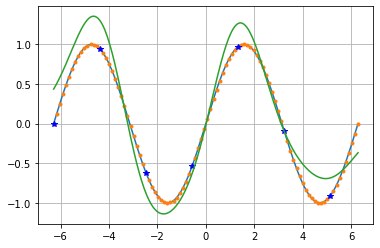

In [453]:
plt.plot(points_x, points_y)
plt.plot(X, y, '.')
plt.plot(krls.points, np.sin(krls.points), '*', color='blue')
predict_y = [krls.predict(x)[0] for x in points_x]
plt.plot(points_x, [krls.predict(xj)[0] for xj in points_x])
plt.grid()

## Зашумлённые данные

In [446]:
np.random.seed(42)
y_noise = np.array([x[0] + np.random.normal(0, 0.2) for x in np.sin(X)]).reshape(len(X), 1)

In [447]:
vs = np.linspace(0, 1, 20)
gammas = np.linspace(0, 1, 20)
min_err = np.inf
best_pair = tuple()
for v in vs:
    for gamma in gammas:
        krls = KRLS(v=v, kernel=lambda x1, x2: rbf(x1,x2, gamma))
        krls.fit(X, y_noise)
        predict_y = [krls.predict(x)[0] for x in points_x]
        err = np.linalg.norm(predict_y - points_y, ord=2)
        if err < min_err:
            min_err = err
            best_pair = (v, gamma)

In [448]:
v, gamma = best_pair
krls = KRLS(v=v, kernel=lambda x1, x2: rbf(x1,x2, gamma))
krls.fit(X, y_noise)

In [449]:
print(best_pair, min_err)

(0.9473684210526315, 0.42105263157894735) 3.4010110912123324


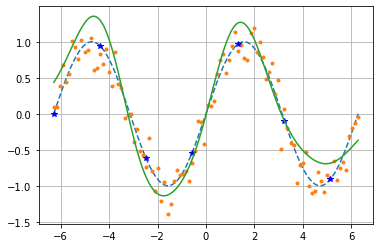

In [452]:
plt.plot(points_x, points_y, linestyle = '--')
plt.plot(X, y_noise, '.')
plt.plot(krls.points, np.sin(krls.points), '*', color='blue')
predict_y = [krls.predict(x)[0] for x in points_x]
plt.plot(points_x, [krls.predict(xj)[0] for xj in points_x])
plt.grid()